# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=modern'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 8
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: false
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: cosine-decay
  langevin_noise: 0.1
  warmup: 50
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 2
    outer_exp: 0.5
    double_opponents: true
  orthogonality:
    scale: 0.0
  norm:
    scale: 1.0e-06
    pnorm: 2
  deep_inversion:
    scale: 0.01



{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [4]:
# cfg.dryrun = False
# cfg.attack.optim.step_size=1.0
cfg.case.user.data_idx = 0
cfg.case.model = 'resnet50'
#cfg.case.server.model_state='moco'

cfg.attack.restarts.num_trials=1
cfg.attack.regularization.deep_inversion.scale=0.01
cfg.attack.regularization.total_variation.scale=0.05
cfg.attack.regularization.norm.scale=0.0
cfg.attack.optim.langevin_noise=0.0

### Instantiate all parties

In [5]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

In [6]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 1
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ResNet
            loss function: CrossEntropyLoss()

            Data:
            Dataset: ImageNet
            data_idx: 0
        


### Simulate an attacked FL protocol

In [7]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# True user data is returned only for analysis

/cmlscratch/jonas0/miniconda3/envs/dl/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


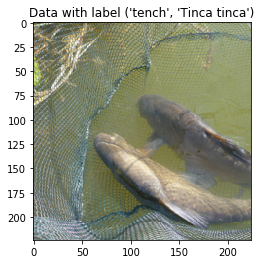

In [8]:
user.plot(true_user_data)

### Reconstruct user data:

In [9]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, server.secrets, shared_data, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, 
                                    true_user_data, server_payload, server.model, setup)

It: 1. Rec. loss: 7.3896. T: 2.06s
It: 1001. Rec. loss: 1.3351. T: 89.20s
It: 2001. Rec. loss: 1.1448. T: 89.48s
It: 3001. Rec. loss: 0.8674. T: 89.58s
It: 4001. Rec. loss: 0.9272. T: 89.57s
It: 5001. Rec. loss: 1.8741. T: 89.55s
It: 6001. Rec. loss: 1.2338. T: 89.61s
It: 7001. Rec. loss: 1.5437. T: 89.47s
It: 8001. Rec. loss: 1.1503. T: 89.48s
It: 9001. Rec. loss: 1.3700. T: 89.50s
It: 10001. Rec. loss: 0.8860. T: 89.48s
It: 11001. Rec. loss: 0.9173. T: 89.64s
It: 12001. Rec. loss: 0.7081. T: 89.66s
It: 13001. Rec. loss: 0.7718. T: 89.58s
It: 14001. Rec. loss: 0.6412. T: 89.60s
It: 15001. Rec. loss: 0.7842. T: 89.63s
It: 16001. Rec. loss: 0.5911. T: 90.20s
It: 17001. Rec. loss: 0.5755. T: 89.61s
It: 18001. Rec. loss: 0.5853. T: 89.45s
It: 19001. Rec. loss: 0.5521. T: 89.59s
It: 20001. Rec. loss: 0.5586. T: 89.48s
It: 21001. Rec. loss: 0.5394. T: 89.61s
It: 22001. Rec. loss: 0.5412. T: 89.50s
It: 23001. Rec. loss: 0.5423. T: 89.61s
It: 24000. Rec. loss: 0.5437. T: 89.40s
Optimal condid

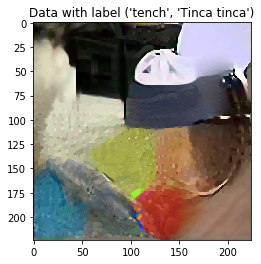

In [10]:
user.plot(reconstructed_user_data)

In [11]:
attacker.regularizers

[TotalVariation(), DeepInversion()]

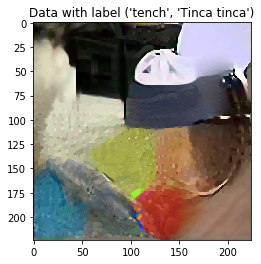

In [12]:
user.plot(reconstructed_user_data)